In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, TimeDistributed, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

In [14]:
# Định nghĩa đường dẫn và các lớp hành động
DATASET_PATH = "/kaggle/input/ucf101-action-recognition/train"  # Đường dẫn tới dữ liệu UCF101
SELECTED_CLASSES = ["WalkingWithDog", "Punch", "JumpRope", "PushUps", "Typing"]  # 5 action labels
NUM_CLASSES = len(SELECTED_CLASSES)
NUM_FRAMES = 20
IMG_SIZE = (64, 64)
CHANNELS = 1  # Grayscale

# Tạo ánh xạ nhãn
class_to_label = {class_name: idx for idx, class_name in enumerate(SELECTED_CLASSES)}  # Ánh xạ tên lớp sang số
label_to_class = {idx: class_name for class_name, idx in class_to_label.items()} # Ánh xạ ngược

# Hàm trích xuất khung hình từ video
def extract_frames(video_path, num_frames=NUM_FRAMES, img_size=IMG_SIZE):
    # Mở video
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

     # Kiểm tra video có đủ frames không
    if total_frames < num_frames:
        cap.release()
        return None

    # Chọn các frames cách đều
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, img_size)
        frames.append(frame)

    cap.release()
    if len(frames) < num_frames:
        return None
    return np.array(frames).reshape(num_frames, img_size[0], img_size[1], CHANNELS)

In [15]:
# Hàm tải dữ liệu UCF101
def load_ucf101_videos(data_path):
    X, Y = [], []
    for class_name in SELECTED_CLASSES:
        class_path = os.path.join(data_path, class_name)
        if not os.path.exists(class_path):
            print(f"Lớp {class_name} không tìm thấy tại {class_path}")
            continue
        videos = os.listdir(class_path)
        for video in videos:
            video_path = os.path.join(class_path, video)
            frames = extract_frames(video_path)
            if frames is not None:
                X.append(frames)
                Y.append(class_to_label[class_name])
    X = np.array(X, dtype=np.float32) / 255.0 # Chuẩn hóa giá trị pixel
    Y = to_categorical(Y, num_classes=NUM_CLASSES) # Mã hóa one-hot cho nhãn
    return X, Y

In [24]:
import numpy as np
import cv2
from collections import Counter
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import rotate, shift, zoom

class VideoDataBalancer:
    """Lớp xử lý dữ liệu mất cân bằng cho dữ liệu video"""
    
    def __init__(self, random_state=42):
        """Khởi tạo bộ cân bằng dữ liệu video"""
        self.random_state = random_state
        np.random.seed(random_state)
    
    def calculate_class_weights(self, y):
        """Tính toán trọng số lớp cho dữ liệu mất cân bằng
        
        Args:
            y: Mảng nhãn lớp (dạng số nguyên, không phải one-hot)
            
        Returns:
            dictionary trọng số cho mỗi lớp
        """
        y_integers = np.argmax(y, axis=1) if len(y.shape) > 1 else y
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_integers),
            y=y_integers
        )
        class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
        print("Trọng số lớp:", class_weights_dict)
        return class_weights_dict
    
    def augment_video(self, video):
        """Áp dụng phép biến đổi ngẫu nhiên cho video
        
        Args:
            video: Video có shape (frames, height, width, channels)
            
        Returns:
            video đã được tăng cường
        """
        augmented_video = np.copy(video)
        frames, height, width, channels = video.shape
        
        # Chọn ngẫu nhiên các phép biến đổi
        augmentation_types = np.random.choice([
            'rotate', 'shift', 'zoom', 'flip', 'brightness'
        ], 2, replace=False)
        
        for aug_type in augmentation_types:
            if aug_type == 'rotate':
                # Xoay video với góc ngẫu nhiên từ -15 đến 15 độ
                angle = np.random.uniform(-15, 15)
                for i in range(frames):
                    augmented_video[i] = rotate(augmented_video[i], angle, reshape=False)
            
            elif aug_type == 'shift':
                # Dịch chuyển video
                x_shift, y_shift = np.random.uniform(-5, 5, 2)
                for i in range(frames):
                    augmented_video[i] = shift(augmented_video[i], [y_shift, x_shift, 0])
            
            elif aug_type == 'zoom':
                # Phóng to/thu nhỏ video
                zoom_factor = np.random.uniform(0.9, 1.1)
                for i in range(frames):
                    augmented_video[i] = zoom(augmented_video[i], [zoom_factor, zoom_factor, 1])
            
            elif aug_type == 'flip':
                # Lật ngang video
                if np.random.random() > 0.5:
                    augmented_video = augmented_video[:, :, ::-1, :]
            
            elif aug_type == 'brightness':
                # Thay đổi độ sáng
                brightness_factor = np.random.uniform(0.8, 1.2)
                augmented_video = np.clip(augmented_video * brightness_factor, 0, 1)
        
        return augmented_video
    
    def oversample_videos(self, X, y, target_count=None):
        """Oversample các lớp thiểu số bằng phương pháp tăng cường dữ liệu
        
        Args:
            X: Mảng video, shape (samples, frames, height, width, channels)
            y: Mảng nhãn, shape (samples, num_classes) nếu one-hot, hoặc (samples,)
            target_count: Số lượng mẫu mục tiêu cho mỗi lớp. Nếu None, sẽ sử dụng lớp đa số.
            
        Returns:
            X_balanced, y_balanced: Dữ liệu đã được cân bằng
        """
        print("Thực hiện oversample dữ liệu video...")
        y_integers = np.argmax(y, axis=1) if len(y.shape) > 1 else y
        class_counts = Counter(y_integers)
        print("Số lượng video trước khi oversample:", dict(class_counts))
        
        if target_count is None:
            target_count = max(class_counts.values())
        
        X_list = []
        y_list = []
        
        for class_label, count in class_counts.items():
            # Tìm các chỉ số của lớp hiện tại
            indices = np.where(y_integers == class_label)[0]
            X_class = X[indices]
            
            # Thêm tất cả dữ liệu gốc vào danh sách mới
            X_list.append(X_class)
            if len(y.shape) > 1:  # y là one-hot
                y_list.append(y[indices])
            else:  # y là dạng số nguyên
                y_list.append(np.full(len(indices), class_label))
            
            # Nếu cần tạo thêm dữ liệu
            if count < target_count:
                # Số lượng dữ liệu cần tạo thêm
                num_to_generate = target_count - count
                
                # Tạo dữ liệu tăng cường
                for _ in range(num_to_generate):
                    # Chọn ngẫu nhiên một mẫu trong lớp
                    sample_idx = np.random.randint(0, len(X_class))
                    sample = X_class[sample_idx]
                    
                    # Tạo mẫu tăng cường
                    augmented_sample = self.augment_video(sample)
                    
                    # Thêm vào danh sách
                    X_list.append(np.expand_dims(augmented_sample, axis=0))
                    if len(y.shape) > 1:  # y là one-hot
                        y_list.append(np.expand_dims(y[indices[sample_idx]], axis=0))
                    else:  # y là dạng số nguyên
                        y_list.append(np.array([class_label]))
        
        # Kết hợp tất cả dữ liệu
        X_balanced = np.vstack([X for X in X_list])
        if len(y.shape) > 1:  # y là one-hot
            y_balanced = np.vstack([y for y in y_list])
        else:  # y là dạng số nguyên
            y_balanced = np.concatenate([y for y in y_list])
        
        # Xáo trộn dữ liệu
        indices = np.random.permutation(len(X_balanced))
        X_balanced = X_balanced[indices]
        y_balanced = y_balanced[indices]
        
        print("Số lượng video sau khi oversample:", dict(Counter(np.argmax(y_balanced, axis=1) if len(y.shape) > 1 else y_balanced)))
        return X_balanced, y_balanced
    
    def undersample_videos(self, X, y, target_count=None):
        """Undersample các lớp đa số để cân bằng với lớp thiểu số
        
        Args:
            X: Mảng video, shape (samples, frames, height, width, channels)
            y: Mảng nhãn, shape (samples, num_classes) nếu one-hot, hoặc (samples,)
            target_count: Số lượng mẫu mục tiêu cho mỗi lớp. Nếu None, sẽ sử dụng lớp thiểu số.
            
        Returns:
            X_balanced, y_balanced: Dữ liệu đã được cân bằng
        """
        print("Thực hiện undersample dữ liệu video...")
        y_integers = np.argmax(y, axis=1) if len(y.shape) > 1 else y
        class_counts = Counter(y_integers)
        print("Số lượng video trước khi undersample:", dict(class_counts))
        
        if target_count is None:
            target_count = min(class_counts.values())
        
        X_list = []
        y_list = []
        
        for class_label, count in class_counts.items():
            # Tìm các chỉ số của lớp hiện tại
            indices = np.where(y_integers == class_label)[0]
            
            # Nếu số lượng mẫu lớn hơn mục tiêu, lấy ngẫu nhiên
            if count > target_count:
                selected_indices = np.random.choice(indices, target_count, replace=False)
            else:
                selected_indices = indices
            
            # Thêm vào danh sách
            X_list.append(X[selected_indices])
            if len(y.shape) > 1:  # y là one-hot
                y_list.append(y[selected_indices])
            else:  # y là dạng số nguyên
                y_list.append(y[selected_indices])
        
        # Kết hợp tất cả dữ liệu
        X_balanced = np.vstack([X for X in X_list])
        if len(y.shape) > 1:  # y là one-hot
            y_balanced = np.vstack([y for y in y_list])
        else:  # y là dạng số nguyên
            y_balanced = np.concatenate([y for y in y_list])
        
        # Xáo trộn dữ liệu
        indices = np.random.permutation(len(X_balanced))
        X_balanced = X_balanced[indices]
        y_balanced = y_balanced[indices]
        
        print("Số lượng video sau khi undersample:", dict(Counter(np.argmax(y_balanced, axis=1) if len(y.shape) > 1 else y_balanced)))
        return X_balanced, y_balanced
    
    def smote_like_videos(self, X, y, k=5, target_ratio=1.0):
        """Phương pháp tương tự SMOTE cho dữ liệu video.
        Tạo video tổng hợp dựa trên nội suy giữa các video gần nhau.
        
        Args:
            X: Mảng video, shape (samples, frames, height, width, channels)
            y: Mảng nhãn, shape (samples, num_classes) nếu one-hot, hoặc (samples,)
            k: Số lượng lân cận gần nhất
            target_ratio: Tỷ lệ mục tiêu so với lớp đa số (1.0 = cân bằng hoàn toàn)
            
        Returns:
            X_balanced, y_balanced: Dữ liệu đã được cân bằng
        """
        print("Thực hiện SMOTE-like cho dữ liệu video...")
        
        # Chuyển đổi dữ liệu video 4D thành dữ liệu 2D để tính khoảng cách
        samples = X.shape[0]
        X_flattened = X.reshape(samples, -1)  # Làm phẳng dữ liệu
        
        y_integers = np.argmax(y, axis=1) if len(y.shape) > 1 else y
        class_counts = Counter(y_integers)
        print("Số lượng video trước khi SMOTE:", dict(class_counts))
        
        # Tìm lớp đa số
        majority_class = max(class_counts, key=class_counts.get)
        majority_count = class_counts[majority_class]
        
        # Chuẩn bị danh sách kết quả
        X_resampled = X.copy()
        y_resampled = y.copy() if len(y.shape) > 1 else y.copy()
        
        # Xử lý từng lớp thiểu số
        for class_label, count in class_counts.items():
            if class_label == majority_class:
                continue
            
            # Tính số lượng mẫu cần tạo thêm
            target_count = int(majority_count * target_ratio)
            if count >= target_count:
                continue
            
            n_samples_to_generate = target_count - count
            
            # Tìm chỉ số của các mẫu thuộc lớp thiểu số hiện tại
            class_indices = np.where(y_integers == class_label)[0]
            
            # Tạo mẫu mới
            for _ in range(n_samples_to_generate):
                # Chọn một mẫu ngẫu nhiên
                reference_idx = np.random.choice(class_indices)
                reference_sample = X_flattened[reference_idx]
                
                # Tính khoảng cách từ mẫu tham chiếu đến tất cả các mẫu trong cùng lớp
                distances = np.sqrt(np.sum((X_flattened[class_indices] - reference_sample) ** 2, axis=1))
                
                # Tìm k lân cận gần nhất (trừ chính nó)
                sorted_indices = np.argsort(distances)
                neighbor_indices = [class_indices[idx] for idx in sorted_indices[1:k+1] if idx < len(class_indices)]
                
                if len(neighbor_indices) == 0:
                    continue
                
                # Chọn một lân cận ngẫu nhiên
                neighbor_idx = np.random.choice(neighbor_indices)
                
                # Tạo mẫu tổng hợp
                interpolation_ratio = np.random.random()
                synthetic_sample_flat = X_flattened[reference_idx] + interpolation_ratio * (X_flattened[neighbor_idx] - X_flattened[reference_idx])
                
                # Reshape lại thành dạng video
                synthetic_sample = synthetic_sample_flat.reshape(X.shape[1:])
                
                # Thêm vào dữ liệu
                X_resampled = np.append(X_resampled, [synthetic_sample], axis=0)
                if len(y.shape) > 1:  # y là one-hot
                    y_resampled = np.append(y_resampled, [y[reference_idx]], axis=0)
                else:  # y là dạng số nguyên
                    y_resampled = np.append(y_resampled, class_label)
        
        # Kiểm tra số lượng sau khi cân bằng
        final_y_integers = np.argmax(y_resampled, axis=1) if len(y.shape) > 1 else y_resampled
        final_class_counts = Counter(final_y_integers)
        print("Số lượng video sau khi SMOTE:", dict(final_class_counts))
        
        return X_resampled, y_resampled

In [27]:
# Tải dữ liệu
X, Y = load_ucf101_videos(DATASET_PATH)
print("Dữ liệu đã tải:", X.shape, Y.shape)

# Kiểm tra số video mỗi nhãn
for class_name in SELECTED_CLASSES:
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.exists(class_path):
        print(f"Lớp {class_name}: {len(os.listdir(class_path))} video")

# Khởi tạo bộ cân bằng dữ liệu
balancer = VideoDataBalancer(random_state=42)

# Chuyển Y từ one-hot về dạng số nguyên để dễ xử lý
Y_numeric = np.argmax(Y, axis=1)

# Áp dụng phương pháp SMOTE-like
X_balanced, Y_balanced = balancer.smote_like_videos(X, Y, k=3)

# Tính toán trọng số lớp nếu muốn sử dụng class weights
class_weights = balancer.calculate_class_weights(Y_numeric)

Dữ liệu đã tải: (495, 20, 64, 64, 1) (495, 5)
Lớp WalkingWithDog: 92 video
Lớp Punch: 120 video
Lớp JumpRope: 108 video
Lớp PushUps: 76 video
Lớp Typing: 102 video
Thực hiện SMOTE-like cho dữ liệu video...
Số lượng video trước khi SMOTE: {0: 89, 1: 120, 2: 108, 3: 76, 4: 102}
Số lượng video sau khi SMOTE: {0: 120, 1: 120, 2: 120, 3: 120, 4: 120}
Trọng số lớp: {0: 1.1123595505617978, 1: 0.825, 2: 0.9166666666666666, 3: 1.3026315789473684, 4: 0.9705882352941176}


In [28]:
# Chia dữ liệu đã cân bằng thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_balanced, Y_balanced, test_size=0.2, random_state=42)
y_train_numeric = np.argmax(y_train, axis=1)
y_test_numeric = np.argmax(y_test, axis=1)
print("Hình dạng tập huấn luyện:", X_train.shape, y_train.shape)
print("Hình dạng tập kiểm tra:", X_test.shape, y_test.shape)

Hình dạng tập huấn luyện: (480, 20, 64, 64, 1) (480, 5)
Hình dạng tập kiểm tra: (120, 20, 64, 64, 1) (120, 5)


# Phương pháp 1: SVM

In [35]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=2000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.models = {}
        self.classes = None
        self.feature_means = None
        self.feature_stds = None
    
    def _normalize_features(self, X, fit=False):
        """Chuẩn hóa đặc trưng để tăng tốc độ hội tụ"""
        if fit:
            self.feature_means = np.mean(X, axis=0)
            self.feature_stds = np.std(X, axis=0) + 1e-8  # Tránh chia cho 0
            return (X - self.feature_means) / self.feature_stds
        else:
            return (X - self.feature_means) / self.feature_stds
    
    def fit(self, X, y):
        """Huấn luyện mô hình SVM với Batch Gradient Descent và tốc độ học được điều chỉnh"""
        # Chuẩn hóa đặc trưng
        X = self._normalize_features(X, fit=True)
        
        # Lấy các lớp duy nhất
        self.classes = np.unique(y)
        
        # Huấn luyện từng mô hình cho mỗi lớp (One-vs-Rest)
        for cls in self.classes:
            print(f"Huấn luyện SVM cho lớp {cls}...")
            y_binary = np.where(y == cls, 1, -1)
            n_samples, n_features = X.shape
            
            # Khởi tạo tham số
            w = np.zeros(n_features)
            b = 0
            
            # Tốc độ học ban đầu
            current_lr = self.lr
            
            # Huấn luyện với cập nhật theo batch
            for iteration in range(self.n_iters):
                # Tính toán margin phân loại cho tất cả mẫu
                margins = y_binary * (np.dot(X, w) + b)
                
                # Xác định mẫu nằm trong biên hoặc bị phân loại sai
                within_margin = margins < 1
                
                # Tính gradient sử dụng toàn bộ batch
                dw = self.lambda_param * w - np.sum(X[within_margin] * y_binary[within_margin].reshape(-1, 1), axis=0) / n_samples
                db = -np.sum(y_binary[within_margin]) / n_samples
                
                # Cập nhật tham số
                w = w - current_lr * dw
                b = b - current_lr * db
                
                # Giảm learning rate sau mỗi giai đoạn
                if (iteration + 1) % 200 == 0:
                    current_lr *= 0.75
                
                # Điều kiện dừng sớm
                if iteration > 500 and np.sum(within_margin) == 0:
                    print(f"Dừng sớm tại vòng lặp {iteration} - đạt phân tách hoàn hảo")
                    break
                    
            # Lưu tham số mô hình
            self.models[cls] = {'w': w, 'b': b}
        
        return self
    
    def predict(self, X):
        """Dự đoán nhãn lớp cho các mẫu trong X"""
        # Chuẩn hóa đặc trưng
        X = self._normalize_features(X)
        
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes)))
        
        # Tính điểm quyết định cho mỗi lớp
        for i, cls in enumerate(self.classes):
            model = self.models[cls]
            scores[:, i] = np.dot(X, model['w']) + model['b']
        
        # Trả về lớp có điểm cao nhất (margin lớn nhất)
        return self.classes[np.argmax(scores, axis=1)]

In [36]:
# Kiểm tra xem dữ liệu đã tồn tại chưa
import os

# Nếu biến X_train_svm chưa được định nghĩa, thử tải từ file
if 'X_train_svm' not in globals():
    # Nếu file đã được lưu trước đó, tải lại
    if os.path.exists('X_train_svm.npy') and os.path.exists('X_test_svm.npy'):
        print("Đang tải dữ liệu đặc trưng từ file...")
        X_train_svm = np.load('X_train_svm.npy')
        X_test_svm = np.load('X_test_svm.npy')
    else:
        # Nếu chưa có file, cần thực hiện trích xuất đặc trưng
        print("Trích xuất đặc trưng cho SVM...")
        resnet = ResNet50(weights='/kaggle/input/resnet50-weight/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                         include_top=False, pooling='avg')
        def extract_features(frames):
            frames_rgb = np.repeat(frames, 3, axis=-1)
            frames_rgb = preprocess_input(frames_rgb)
            features = resnet.predict(frames_rgb, batch_size=32)
            return np.mean(features, axis=0)
        
        X_train_svm = np.array([extract_features(video) for video in X_train])
        X_test_svm = np.array([extract_features(video) for video in X_test])
        print("Hình dạng đặc trưng SVM:", X_train_svm.shape, X_test_svm.shape)
        
        # Lưu đặc trưng để sử dụng sau này
        np.save('X_train_svm.npy', X_train_svm)
        np.save('X_test_svm.npy', X_test_svm)

print("Đặc trưng đã sẵn sàng:", X_train_svm.shape)

Đặc trưng đã sẵn sàng: (480, 2048)


In [37]:
# Huấn luyện và đánh giá Enhanced SVM
svm = SVM(learning_rate=0.01, lambda_param=0.01, n_iters=2000)
svm.fit(X_train_svm, y_train_numeric)
svm_pred = svm.predict(X_test_svm)
svm_acc = accuracy_score(y_test_numeric, svm_pred)
svm_f1 = f1_score(y_test_numeric, svm_pred, average='weighted')
svm_cm = confusion_matrix(y_test_numeric, svm_pred)
svm_report = classification_report(y_test_numeric, svm_pred, target_names=SELECTED_CLASSES)

Huấn luyện SVM cho lớp 0...
Huấn luyện SVM cho lớp 1...
Huấn luyện SVM cho lớp 2...
Huấn luyện SVM cho lớp 3...
Huấn luyện SVM cho lớp 4...


In [38]:
print("\nKết quả SVM:")
print(f"Độ chính xác: {svm_acc:.4f}")
print(f"F1-Score (Weighted): {svm_f1:.4f}")
print("Báo cáo phân loại:\n", svm_report)


Kết quả SVM:
Độ chính xác: 0.8667
F1-Score (Weighted): 0.8611
Báo cáo phân loại:
                 precision    recall  f1-score   support

WalkingWithDog       0.78      0.58      0.67        24
         Punch       0.83      0.91      0.87        22
      JumpRope       0.88      0.92      0.90        25
       PushUps       0.85      0.96      0.90        23
        Typing       0.96      0.96      0.96        26

      accuracy                           0.87       120
     macro avg       0.86      0.87      0.86       120
  weighted avg       0.86      0.87      0.86       120



In [39]:
# Sklearn SVC
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train_svm, y_train_numeric)
svc_pred = svc.predict(X_test_svm)
svc_acc = accuracy_score(y_test_numeric, svc_pred)
svc_f1 = f1_score(y_test_numeric, svc_pred, average='weighted')
svc_cm = confusion_matrix(y_test_numeric, svc_pred)
svc_report = classification_report(y_test_numeric, svc_pred, target_names=SELECTED_CLASSES)

print("\nKết quả Sklearn SVC:")
print(f"Độ chính xác: {svc_acc:.4f}")
print(f"F1-Score (Weighted): {svc_f1:.4f}")
print("Báo cáo phân loại:\n", svc_report)


Kết quả Sklearn SVC:
Độ chính xác: 0.8667
F1-Score (Weighted): 0.8641
Báo cáo phân loại:
                 precision    recall  f1-score   support

WalkingWithDog       0.76      0.67      0.71        24
         Punch       0.91      0.91      0.91        22
      JumpRope       0.91      0.80      0.85        25
       PushUps       0.79      0.96      0.86        23
        Typing       0.96      1.00      0.98        26

      accuracy                           0.87       120
     macro avg       0.87      0.87      0.86       120
  weighted avg       0.87      0.87      0.86       120



# Phương pháp 2: Random Forest 


In [40]:
# --- Phương pháp 2: Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_svm, y_train_numeric)
rf_pred = rf.predict(X_test_svm)
rf_acc = accuracy_score(y_test_numeric, rf_pred)
rf_f1 = f1_score(y_test_numeric, rf_pred, average='weighted')
rf_cm = confusion_matrix(y_test_numeric, rf_pred)
rf_report = classification_report(y_test_numeric, rf_pred, target_names=SELECTED_CLASSES)

print("\nKết quả Random Forest:")
print(f"Độ chính xác: {rf_acc:.4f}")
print(f"F1-Score (Weighted): {rf_f1:.4f}")
print("Báo cáo phân loại:\n", rf_report)


Kết quả Random Forest:
Độ chính xác: 0.9167
F1-Score (Weighted): 0.9162
Báo cáo phân loại:
                 precision    recall  f1-score   support

WalkingWithDog       0.90      0.79      0.84        24
         Punch       0.87      0.91      0.89        22
      JumpRope       1.00      0.92      0.96        25
       PushUps       0.85      0.96      0.90        23
        Typing       0.96      1.00      0.98        26

      accuracy                           0.92       120
     macro avg       0.92      0.92      0.91       120
  weighted avg       0.92      0.92      0.92       120



# Phương pháp 3: CNN-LSTM 


In [41]:
from keras.layers import LeakyReLU

In [42]:
# Xây dựng mô hình CNN-LSTM
cnn_lstm_model = Sequential()
cnn_lstm_model.add(TimeDistributed(Conv2D(32, (3, 3), activation='linear', padding='same'), input_shape=(NUM_FRAMES, IMG_SIZE[0], IMG_SIZE[1], CHANNELS)))
cnn_lstm_model.add(TimeDistributed(LeakyReLU(negative_slope=0.1)))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
cnn_lstm_model.add(TimeDistributed(Conv2D(64, (3, 3), activation='linear', padding='same')))
cnn_lstm_model.add(TimeDistributed(LeakyReLU(negative_slope=0.1)))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
cnn_lstm_model.add(TimeDistributed(Conv2D(128, (3, 3), activation='linear', padding='same')))
cnn_lstm_model.add(TimeDistributed(LeakyReLU(negative_slope=0.1)))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
cnn_lstm_model.add(TimeDistributed(Flatten()))
cnn_lstm_model.add(LSTM(128, return_sequences=False))
cnn_lstm_model.add(Dense(128, activation='linear'))
cnn_lstm_model.add(LeakyReLU(negative_slope=0.1))
cnn_lstm_model.add(Dense(NUM_CLASSES, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# Biên dịch mô hình
cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 64, 64, 32)      │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 32, 32, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 32, 32, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 16, 16, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 16, 16, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 8, 8, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 8192)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       4,260,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,370,181 (16.67 MB)

 Trainable params: 4,370,181 (16.67 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from keras.callbacks import EarlyStopping

# Callback để tối ưu huấn luyện
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [46]:
# Huấn luyện CNN-LSTM 
BATCH_SIZE = 32
EPOCHS = 30
cnn_lstm_history = cnn_lstm_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - accuracy: 0.2464 - loss: 1.5511 - val_accuracy: 0.6083 - val_loss: 1.0978
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.5459 - loss: 1.0879 - val_accuracy: 0.6667 - val_loss: 0.8736
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.7228 - loss: 0.7171 - val_accuracy: 0.7417 - val_loss: 0.6922
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.8133 - loss: 0.4663 - val_accuracy: 0.8417 - val_loss: 0.4966
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.9236 - loss: 0.2590 - val_accuracy: 0.8667 - val_loss: 0.3702
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.9447 - loss: 0.1575 - val_accuracy: 0.9333 - val_loss: 0.2711
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.9893 - loss: 0.0475 - val_accuracy: 0.9417 - val_loss: 0.2463
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.9989 - loss: 0.0165 - val_accuracy: 0

In [47]:
# Đánh giá CNN-LSTM
cnn_lstm_pred = cnn_lstm_model.predict(X_test)
cnn_lstm_pred_classes = np.argmax(cnn_lstm_pred, axis=1)
cnn_lstm_acc = accuracy_score(y_test_numeric, cnn_lstm_pred_classes)
cnn_lstm_f1 = f1_score(y_test_numeric, cnn_lstm_pred_classes, average='weighted')
cnn_lstm_cm = confusion_matrix(y_test_numeric, cnn_lstm_pred_classes)
cnn_lstm_report = classification_report(y_test_numeric, cnn_lstm_pred_classes, target_names=SELECTED_CLASSES)

print("\nKết quả CNN-LSTM:")
print(f"Độ chính xác: {cnn_lstm_acc:.4f}")
print(f"F1-Score (Weighted): {cnn_lstm_f1:.4f}")
print("Báo cáo phân loại:\n", cnn_lstm_report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 660ms/step

Kết quả CNN-LSTM:
Độ chính xác: 0.9417
F1-Score (Weighted): 0.9393
Báo cáo phân loại:
                 precision    recall  f1-score   support

WalkingWithDog       1.00      0.75      0.86        24
         Punch       0.96      1.00      0.98        22
      JumpRope       0.93      1.00      0.96        25
       PushUps       0.88      0.96      0.92        23
        Typing       0.96      1.00      0.98        26

      accuracy                           0.94       120
     macro avg       0.95      0.94      0.94       120
  weighted avg       0.95      0.94      0.94       120



# Visualization

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


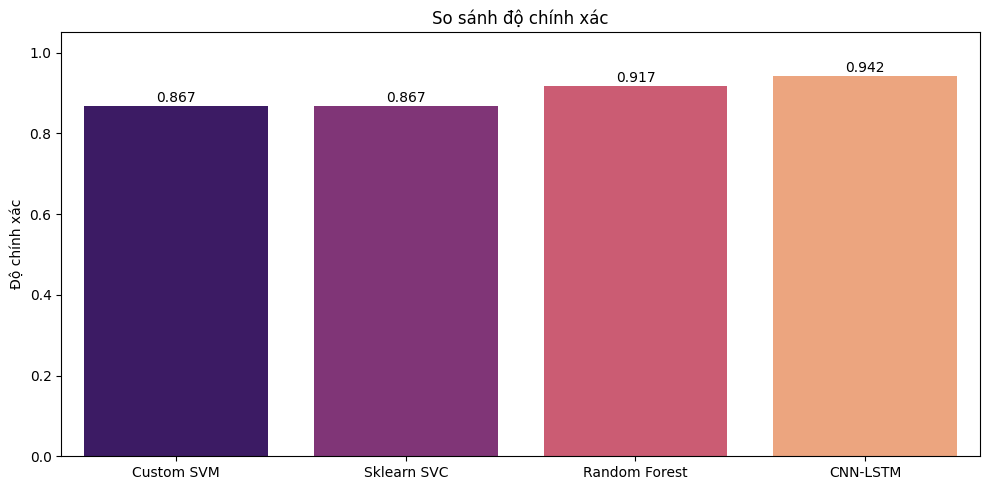

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


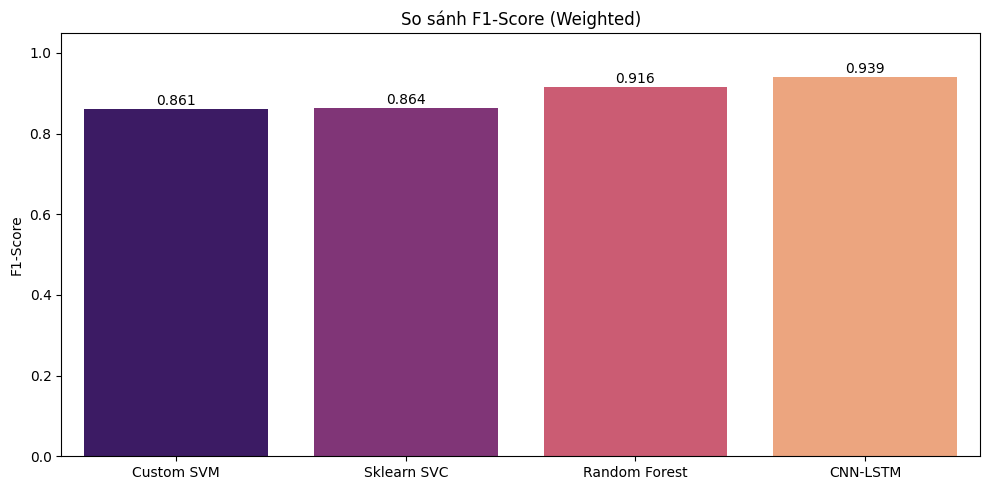

In [49]:
# --- Trực quan hóa ---
# So sánh Accuracy và F1-Score
methods = ['Custom SVM', 'Sklearn SVC', 'Random Forest', 'CNN-LSTM']
accuracies = [svm_acc, svc_acc, rf_acc, cnn_lstm_acc]
f1_scores = [svm_f1, svc_f1, rf_f1, cnn_lstm_f1]

plt.figure(figsize=(10, 5))
sns.barplot(x=methods, y=accuracies, palette='magma')
plt.title('So sánh độ chính xác')
plt.ylabel('Độ chính xác')
plt.ylim(0, 1.05)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('accuracy_comparison.png')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=methods, y=f1_scores, palette='magma')
plt.title('So sánh F1-Score (Weighted)')
plt.ylabel('F1-Score')
plt.ylim(0, 1.05)
for i, f1 in enumerate(f1_scores):
    plt.text(i, f1 + 0.01, f'{f1:.3f}', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('f1_score_comparison.png')
plt.show()


In [50]:
# Vẽ ma trận nhầm lẫn
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES)
    plt.title(title)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

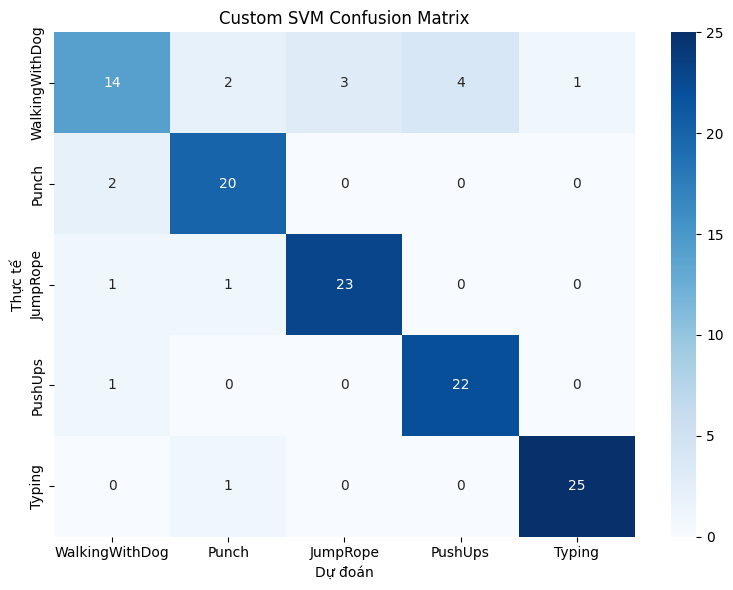

In [52]:
plot_confusion_matrix(svm_cm, 'Custom SVM Confusion Matrix')

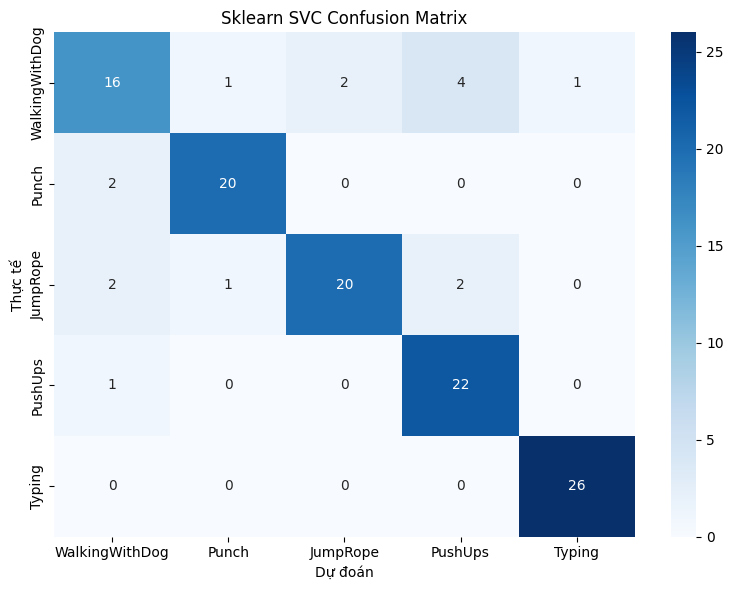

In [53]:
plot_confusion_matrix(svc_cm, 'Sklearn SVC Confusion Matrix')

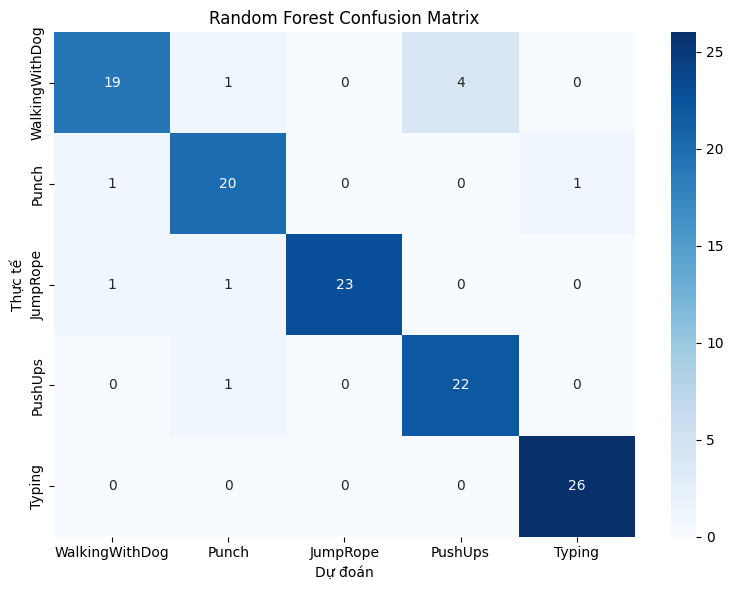

In [54]:
plot_confusion_matrix(rf_cm, 'Random Forest Confusion Matrix')

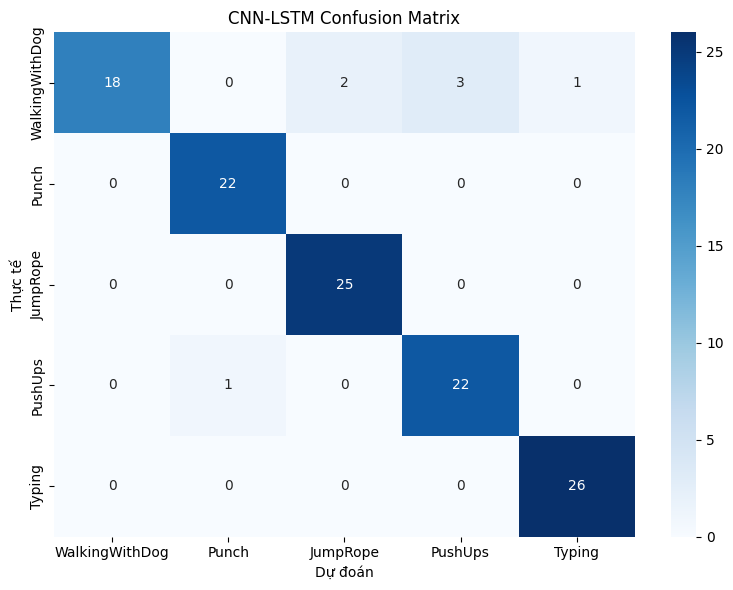

In [55]:
plot_confusion_matrix(cnn_lstm_cm, 'CNN-LSTM Confusion Matrix')

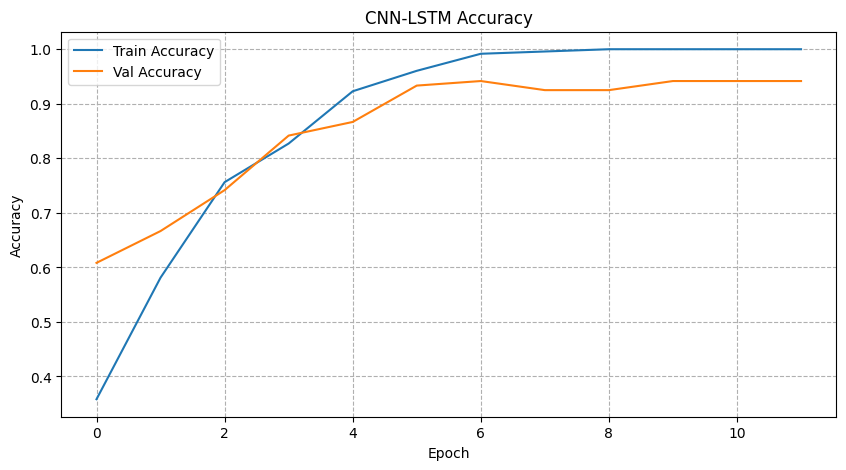

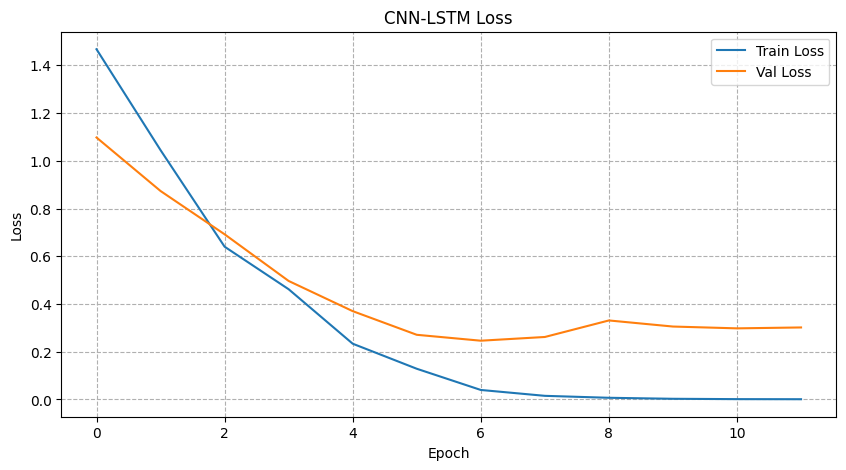

In [56]:
# Vẽ lịch sử huấn luyện CNN-LSTM
plt.figure(figsize=(10, 5))
plt.plot(cnn_lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_lstm_history.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN-LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(linestyle='--')
plt.savefig('cnn_lstm_accuracy_history.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cnn_lstm_history.history['loss'], label='Train Loss')
plt.plot(cnn_lstm_history.history['val_loss'], label='Val Loss')
plt.title('CNN-LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(linestyle='--')
plt.savefig('cnn_lstm_loss_history.png')
plt.show()

In [ ]:
# --- Lưu mô hình ---
# Lưu CNN-LSTM
cnn_lstm_model.save('ucf101_cnn_lstm_model.h5')

# Lưu SVM và Random Forest
with open('svm.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('svc.pkl', 'wb') as f:
    pickle.dump(svc, f)
with open('rf.pkl', 'wb') as f:
    pickle.dump(rf, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(class_to_label, f)

# Ứng dụng: Dự đoán hành động từ video 


In [59]:
def predict_action(video_input, model_type='cnn_lstm', cnn_lstm_model=None, svm_model=None, rf_model=None, frame_count=NUM_FRAMES):
    # Kiểm tra xem input là file path hay array
    if isinstance(video_input, str):
        frames = extract_frames(video_input, frame_count)
        if frames is None:
            return "Lỗi: Không thể xử lý video."
        frames = frames / 255.0  # Chuẩn hóa
    elif isinstance(video_input, np.ndarray) and video_input.shape == (frame_count, IMG_SIZE[0], IMG_SIZE[1], CHANNELS):
        frames = video_input  # Đã được chuẩn hóa trước
    else:
        return "Lỗi: Đầu vào không hợp lệ. Cần đường dẫn video hoặc array có shape đúng."

    if model_type == 'cnn_lstm':
        frames = np.expand_dims(frames, axis=0)
        pred = cnn_lstm_model.predict(frames)
        pred_class = np.argmax(pred, axis=1)[0]
        return label_to_class[pred_class]
    elif model_type == 'svm':
        features = extract_features(frames)
        features = features.reshape(1, -1)
        pred = svm_model.predict(features)
        return label_to_class[pred[0]]
    else:  # Random Forest
        features = extract_features(frames)
        features = features.reshape(1, -1)
        pred = rf_model.predict(features)
        return label_to_class[pred[0]]

In [60]:
# Ví dụ sử dụng với video kiểm tra
random_index = np.random.randint(0, len(X_test))
test_video = X_test[random_index]
actual_label = label_to_class[np.argmax(y_test[random_index])]

In [61]:
# Dự đoán với CNN-LSTM
cnn_lstm_pred_label = predict_action(test_video, model_type='cnn_lstm', cnn_lstm_model=cnn_lstm_model)
print(f"Dự đoán CNN-LSTM: {cnn_lstm_pred_label}, Thực tế: {actual_label}")

# Dự đoán với Sklearn SVC
svc_pred_label = predict_action(test_video, model_type='svm', svm_model=svc)
print(f"Dự đoán Sklearn SVC: {svc_pred_label}, Thực tế: {actual_label}")

# Dự đoán với Random Forest
rf_pred_label = predict_action(test_video, model_type='rf', rf_model=rf)
print(f"Dự đoán Random Forest: {rf_pred_label}, Thực tế: {actual_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Dự đoán CNN-LSTM: PushUps, Thực tế: PushUps
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Dự đoán Sklearn SVC: PushUps, Thực tế: PushUps
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Dự đoán Random Forest: PushUps, Thực tế: PushUps


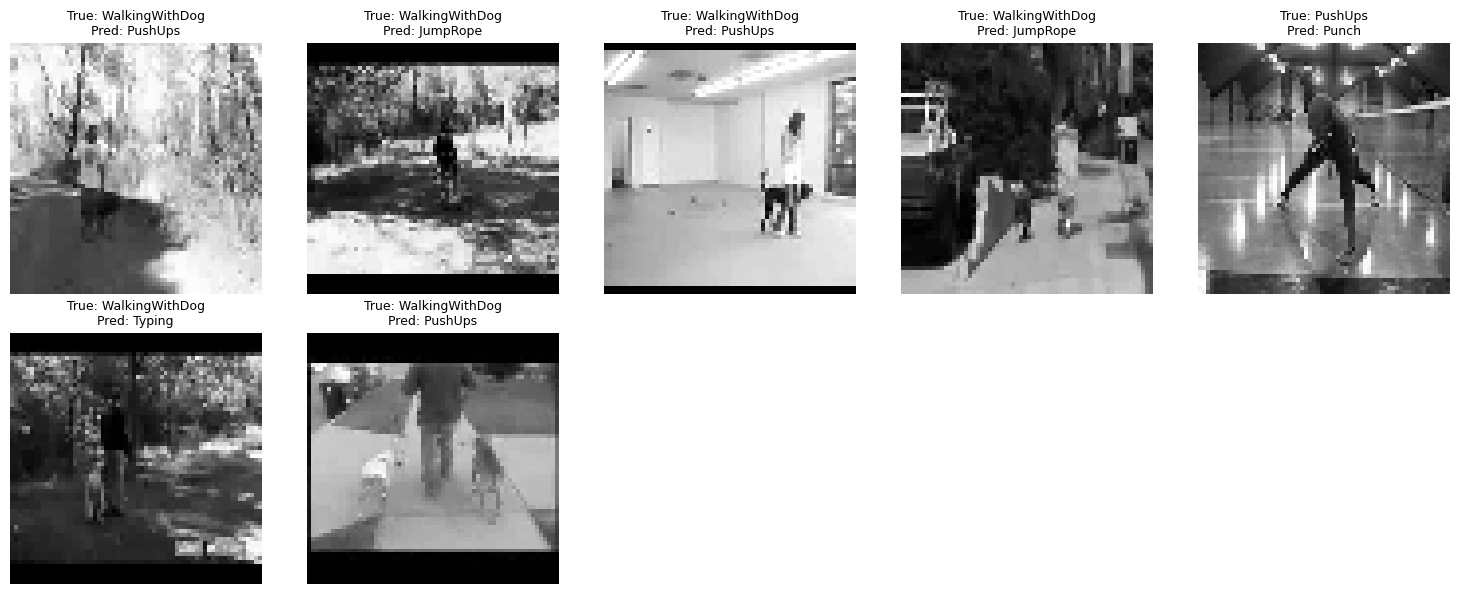

True Label: WalkingWithDog
Predicted Label: PushUps
Predicted Probabilities: [7.7833511e-02 8.6767966e-04 8.1078159e-03 9.1246915e-01 7.2185311e-04]
--------------------------------------------------
True Label: WalkingWithDog
Predicted Label: JumpRope
Predicted Probabilities: [0.03548791 0.00151197 0.57734674 0.00405381 0.38159955]
--------------------------------------------------
True Label: WalkingWithDog
Predicted Label: PushUps
Predicted Probabilities: [7.9406574e-02 1.9465623e-03 1.1744176e-04 9.1782594e-01 7.0356746e-04]
--------------------------------------------------
True Label: WalkingWithDog
Predicted Label: JumpRope
Predicted Probabilities: [0.19405118 0.01287441 0.5368664  0.2534528  0.00275516]
--------------------------------------------------
True Label: PushUps
Predicted Label: Punch
Predicted Probabilities: [2.4375656e-01 7.3713213e-01 2.3780939e-04 1.8044224e-02 8.2930014e-04]
--------------------------------------------------


In [ ]:
import random

# Lấy chỉ số các mẫu bị phân loại sai
misclassified_indices = np.where(cnn_lstm_pred_classes != y_test_numeric)[0]

# Shuffle và chọn tối đa 10 mẫu để hiển thị
num_samples = min(10, len(misclassified_indices))
misclassified_samples = random.sample(list(misclassified_indices), num_samples)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(misclassified_samples):
    plt.subplot(2, 5, i + 1)
    first_frame = X_test[idx][0, :, :, 0] if CHANNELS == 1 else X_test[idx][0]  # Lấy frame đầu tiên
    cmap = 'gray' if CHANNELS == 1 else None
    plt.imshow(first_frame, cmap=cmap)
    true_label = SELECTED_CLASSES[y_test_numeric[idx]]
    predicted_label = SELECTED_CLASSES[cnn_lstm_pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# In ra một số mẫu bị sai kèm xác suất dự đoán
for idx in misclassified_samples[:5]:  # Tối đa 5 mẫu
    print(f"True Label: {SELECTED_CLASSES[y_test_numeric[idx]]}")
    print(f"Predicted Label: {SELECTED_CLASSES[cnn_lstm_pred_classes[idx]]}")
    print(f"Predicted Probabilities: {cnn_lstm_pred[idx]}")
    print("-" * 50)
